In [ ]:
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.5-cp311-cp311-linux_x86_64.whl size=113656 sha256=0afa1202a3286876a2e210cfa3f292cb23c98415cc808a382afd07be610f7216
  Stored in directory: /root/.cache/pip/wheels/79/9b/3d/e6f1189c5a4a3ff41788a9e37ced0cd0cb0d2af46974aadfbb
Successfully built pycatch22


In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 1.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
# =====================================
# ECG Classifier (Catch22 features + RF/SVM/XGBoost)
# Memory Classifier: Five vs Nine vs Thirteen
# Binary Classifier: JustListen vs Memory
# =====================================

import numpy as np
import pickle
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import RandomOverSampler
from joblib import dump
from tqdm import tqdm
from scipy.signal import resample
from pycatch22 import catch22_all

warnings.filterwarnings("ignore")
np.random.seed(42)


In [ ]:
# === Load ECG data ===
with open("/content/drive/MyDrive/output_ecg_data/processed_ecg_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

data = data_dict["data"]

# === Utility functions ===
def clean_signals(X):
    X = np.nan_to_num(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / (np.std(X, axis=1, keepdims=True) + 1e-8)

def downsample_signals(X, target_len=2000):
    return np.array([resample(sig, target_len) for sig in X])

def extract_features(X_signals):
    return np.array([catch22_all(sig)["values"] for sig in tqdm(X_signals, desc="🔍 Extracting Catch22")])

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

def plot_roc_auc(y_true, y_prob, n_classes, title="ROC Curve"):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def train_classifier(X, y, label_names, model, model_name, is_binary=False):
    print(f"\n⚙️ Training classifier: {model_name}")

    # Fix y labels to be 1D
    y = np.array(y).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # Cross-Validation
    print("\n🔎 Performing 5-Fold Cross-Validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="accuracy", n_jobs=-1)
    print(f"✅ Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    start_time = time.time()

    model.fit(X_train_res, y_train_res)

    end_time = time.time()
    print(f"⏱️ Training Time: {end_time - start_time:.2f} seconds")

    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred).ravel()   # Flatten prediction

    y_proba = model.predict_proba(X_test)

    # Now everything is clean 1D for metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ Test Accuracy: {acc:.4f}")
    print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_names))

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, labels=label_names, title=f"{model_name} - Confusion Matrix")

    # ROC
    if is_binary:
        if y_proba.shape[1] == 2:
            positive_class_probs = y_proba[:, 1]
        else:
            positive_class_probs = y_proba.ravel()  # in case it's weirdly shaped

        roc_auc = roc_auc_score(y_test, positive_class_probs)
        fpr, tpr, _ = roc_curve(y_test, positive_class_probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} - ROC Curve")
        plt.legend()
        plt.show()
    else:
        plot_roc_auc(y_test, y_proba, n_classes=len(label_names), title=f"{model_name} - ROC Curve")


    # Feature Importance
    if isinstance(model, RandomForestClassifier):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:10]
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(indices)), importances[indices], align="center")
        plt.xticks(range(len(indices)), [f"Feature {i}" for i in indices], rotation=45)
        plt.title(f"{model_name} - Top 10 Feature Importances")
        plt.show()

    elif isinstance(model, XGBClassifier):
        plt.figure(figsize=(10, 6))
        plot_importance(model, max_num_features=10)
        plt.title(f"{model_name} - Top 10 Feature Importances")
        plt.show()

    # Save model
    dump(model, f"{model_name}.joblib")
    print(f"✅ Model saved as '{model_name}.joblib'")


📉 Normalizing and downsampling memory signals...
✅ Shape after downsampling - X_mem: (6990, 2000)

🔄 Extracting features for memory classifier...


🔍 Extracting Catch22: 100%|██████████| 6990/6990 [02:12<00:00, 52.91it/s]



⚙️ Training classifier: memory_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.9833 ± 0.0045
⏱️ Training Time: 7.99 seconds

✅ Test Accuracy: 0.9771

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       1.00      0.99      0.99       599
    Nine-Memory       0.99      0.95      0.97       585
Thirteen-Memory       0.94      0.99      0.97       564

       accuracy                           0.98      1748
      macro avg       0.98      0.98      0.98      1748
   weighted avg       0.98      0.98      0.98      1748



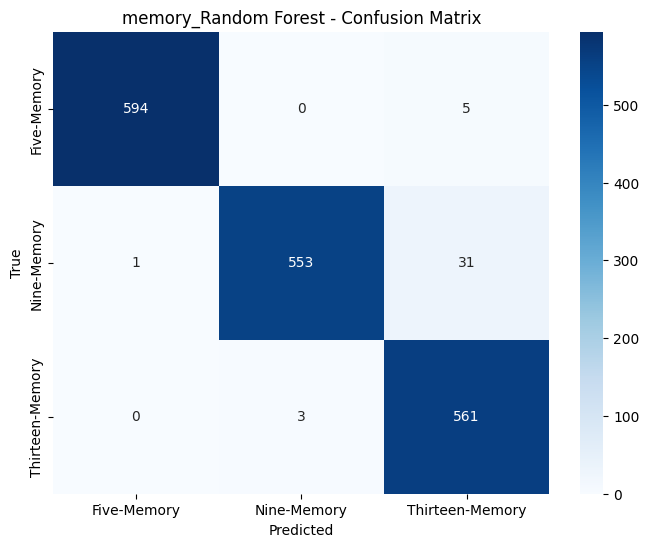

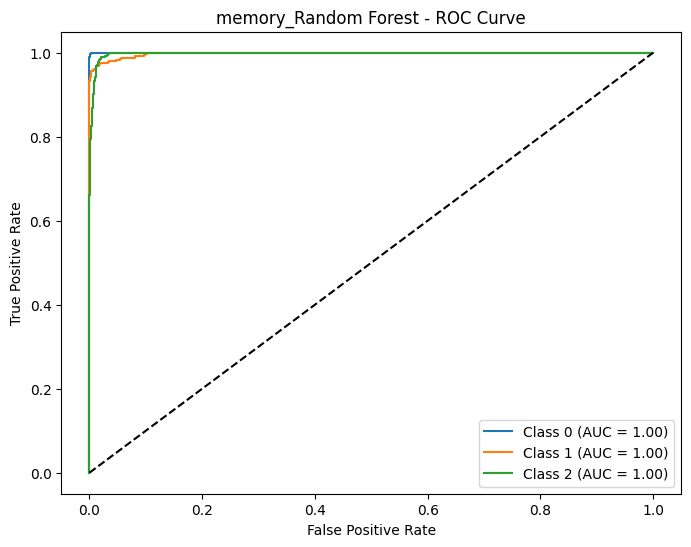

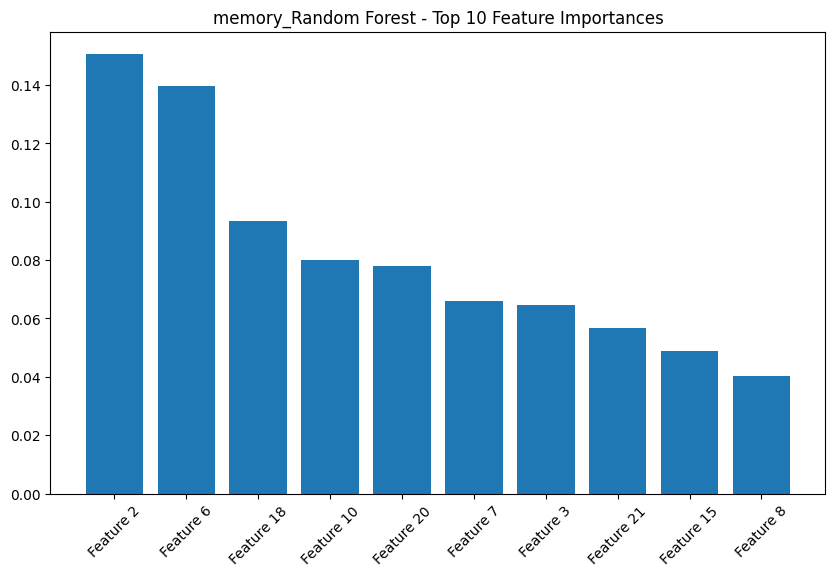

✅ Model saved as 'memory_Random Forest.joblib'

⚙️ Training classifier: memory_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.9050 ± 0.0100
⏱️ Training Time: 1.76 seconds

✅ Test Accuracy: 0.8919

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       0.99      0.92      0.95       599
    Nine-Memory       0.95      0.80      0.87       585
Thirteen-Memory       0.78      0.96      0.86       564

       accuracy                           0.89      1748
      macro avg       0.90      0.89      0.89      1748
   weighted avg       0.91      0.89      0.89      1748



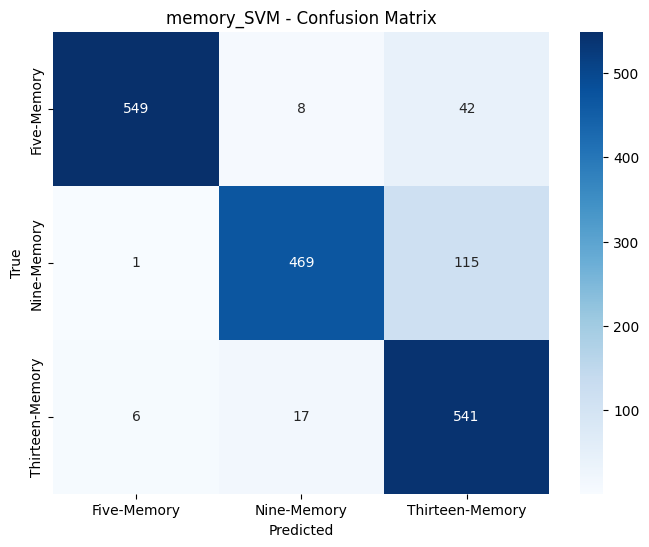

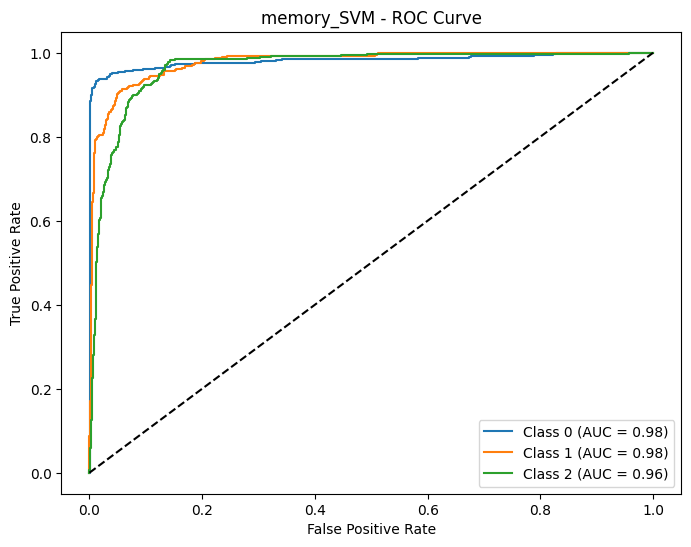

✅ Model saved as 'memory_SVM.joblib'

⚙️ Training classifier: memory_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.9850 ± 0.0035
⏱️ Training Time: 5.54 seconds

✅ Test Accuracy: 0.9868

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       1.00      1.00      1.00       599
    Nine-Memory       0.99      0.97      0.98       585
Thirteen-Memory       0.97      0.99      0.98       564

       accuracy                           0.99      1748
      macro avg       0.99      0.99      0.99      1748
   weighted avg       0.99      0.99      0.99      1748



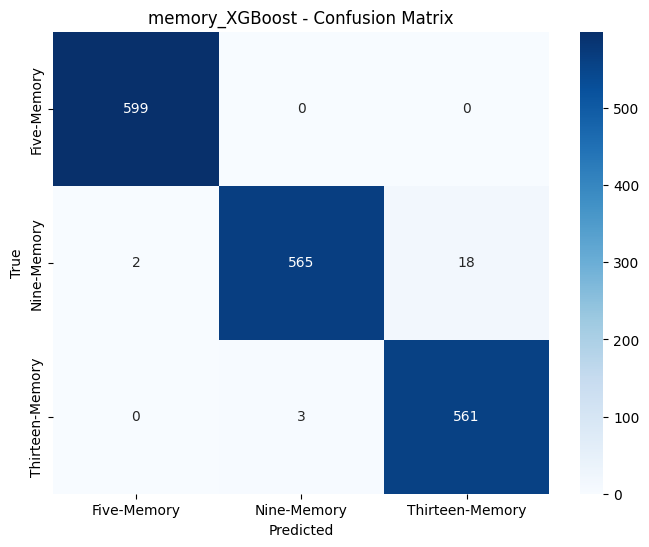

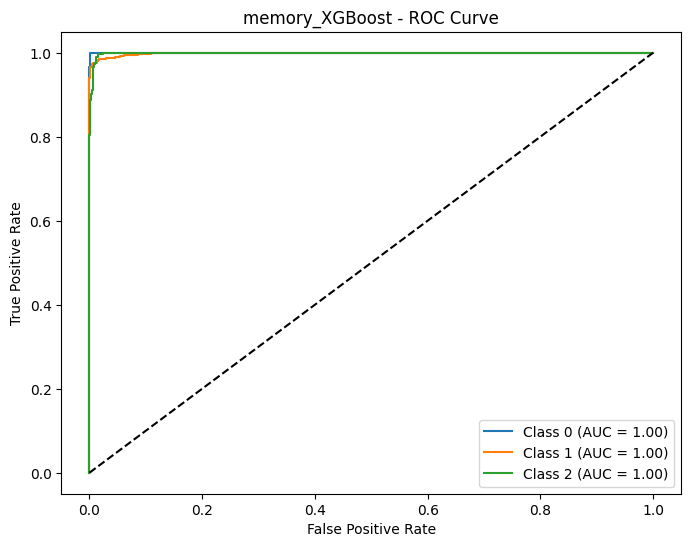

<Figure size 1000x600 with 0 Axes>

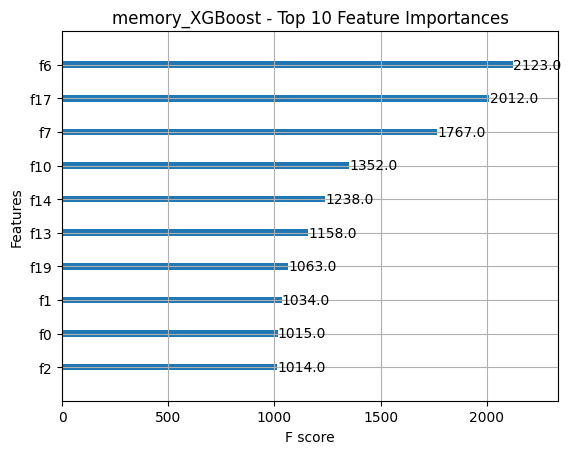

✅ Model saved as 'memory_XGBoost.joblib'


In [ ]:
# === Data Preparation for Memory Classifier ===
X_mem, y_mem = [], []
memory_label_map = {
    "Five-Memory": 0,
    "Nine-Memory": 1,
    "Thirteen-Memory": 2
}

for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        for subcond_idx in [1, 2]:  # Memory Correct, Memory Incorrect
            for trial_idx in range(54):
                signal = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(signal).all():
                    label = f"{condition}-Memory"
                    X_mem.append(signal)
                    y_mem.append(memory_label_map[label])

X_mem = np.array(X_mem)
print("📉 Normalizing and downsampling memory signals...")
X_mem = clean_signals(X_mem)
X_mem = downsample_signals(X_mem, target_len=2000)
print("✅ Shape after downsampling - X_mem:", X_mem.shape)

print("\n🔄 Extracting features for memory classifier...")
X_mem_features = extract_features(X_mem)

# === Models ===
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500, max_depth=10, min_samples_split=5,bootstrap= False, max_features='sqrt', min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
    n_estimators=500, max_depth=10, learning_rate=0.05,
    objective="multi:softprob", num_class=3, random_state=42, n_jobs=-1
    ),

}

# === Training on Memory Classifier ===
for model_name, model in models.items():
    train_classifier(X_mem_features, np.array(y_mem), list(memory_label_map.keys()), model, f"memory_{model_name}", is_binary=False)


📉 Normalizing and downsampling binary signals...
✅ Shape after downsampling - X_jm: (10241, 2000)

🔄 Extracting features for binary classifier...


🔍 Extracting Catch22: 100%|██████████| 10241/10241 [03:06<00:00, 55.01it/s]



⚙️ Training classifier: justlisten_vs_memory_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.6659 ± 0.0124
⏱️ Training Time: 15.29 seconds

✅ Test Accuracy: 0.5838

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.35      0.38      0.37       813
      Memory       0.70      0.68      0.69      1748

    accuracy                           0.58      2561
   macro avg       0.53      0.53      0.53      2561
weighted avg       0.59      0.58      0.59      2561



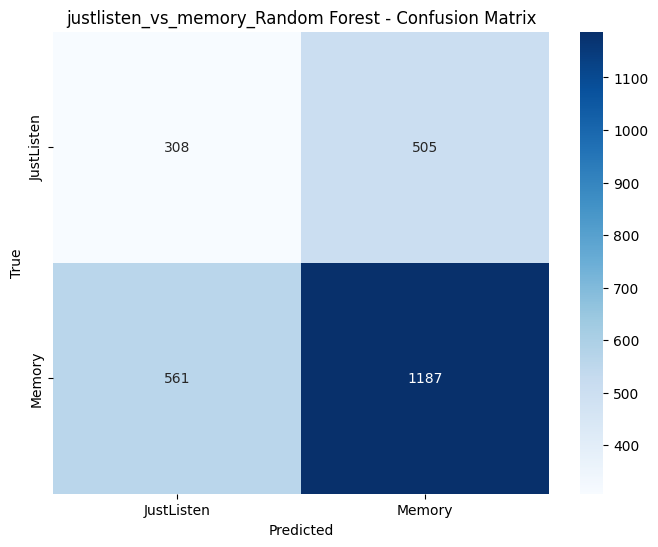

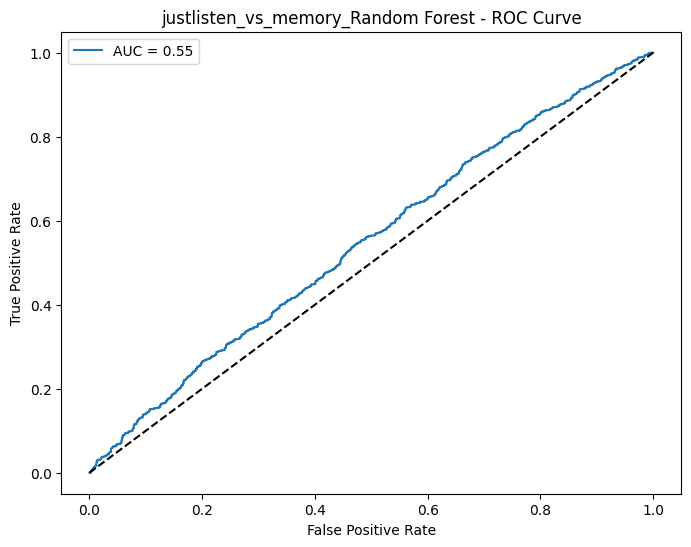

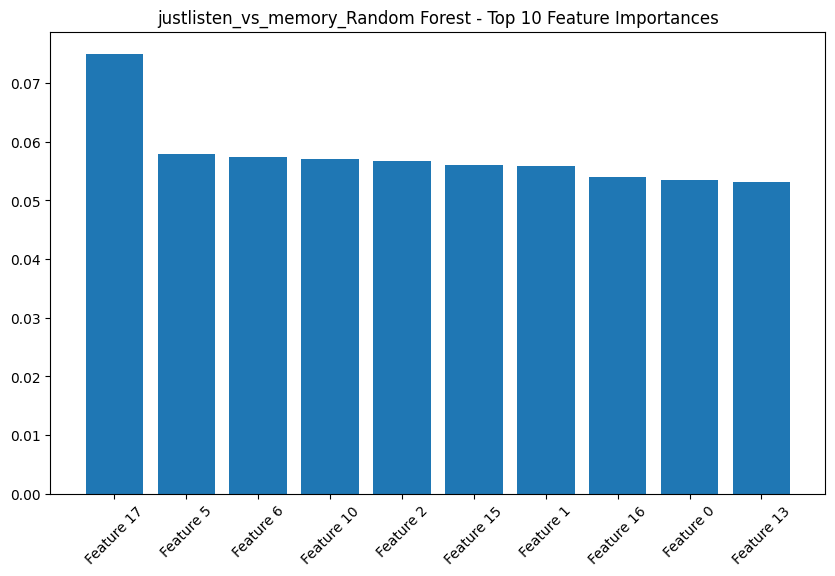

✅ Model saved as 'justlisten_vs_memory_Random Forest.joblib'

⚙️ Training classifier: justlisten_vs_memory_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.5163 ± 0.0081
⏱️ Training Time: 44.71 seconds

✅ Test Accuracy: 0.4455

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.31      0.63      0.42       813
      Memory       0.68      0.36      0.47      1748

    accuracy                           0.45      2561
   macro avg       0.49      0.49      0.44      2561
weighted avg       0.56      0.45      0.45      2561



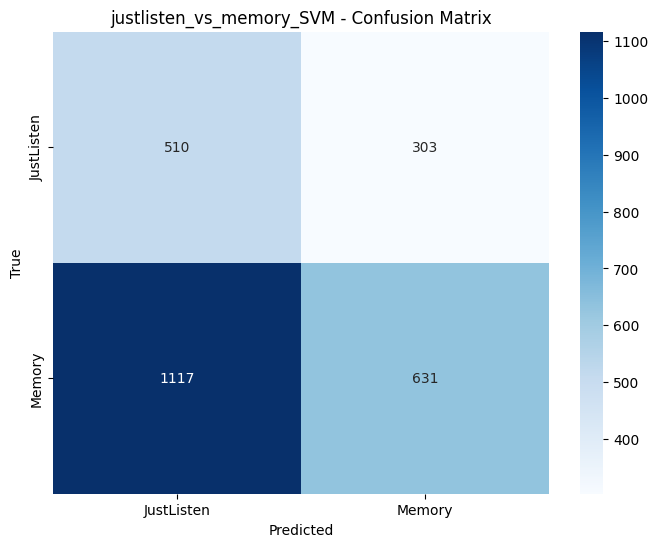

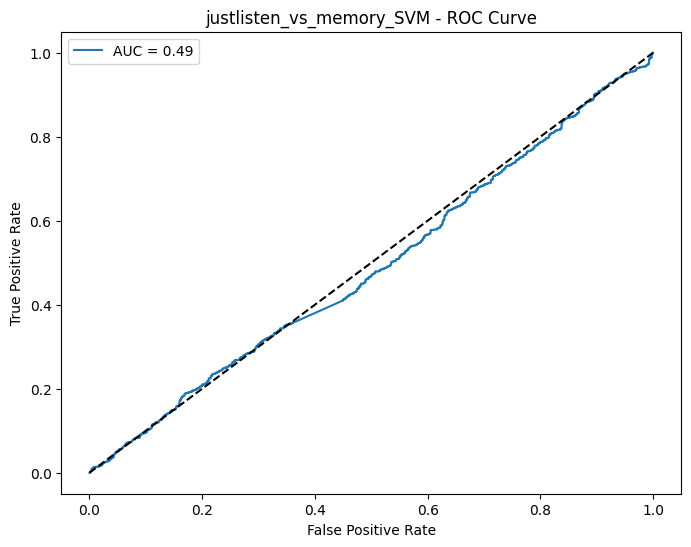

✅ Model saved as 'justlisten_vs_memory_SVM.joblib'

⚙️ Training classifier: justlisten_vs_memory_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.7340 ± 0.0070
⏱️ Training Time: 4.37 seconds

✅ Test Accuracy: 0.5978

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.36      0.34      0.35       813
      Memory       0.70      0.72      0.71      1748

    accuracy                           0.60      2561
   macro avg       0.53      0.53      0.53      2561
weighted avg       0.59      0.60      0.59      2561



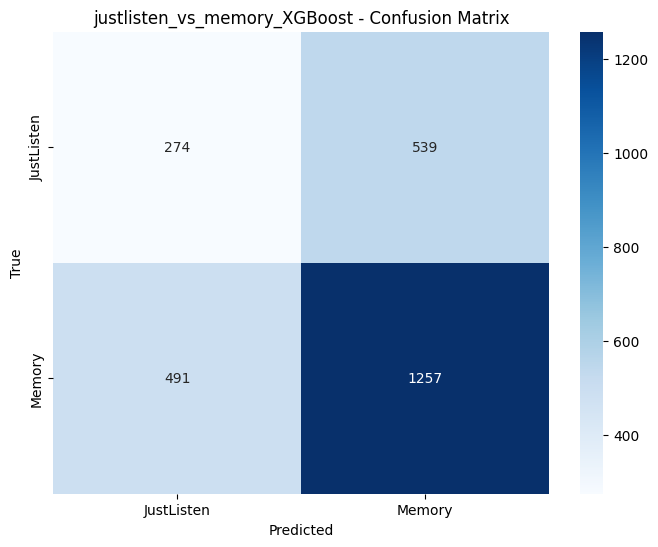

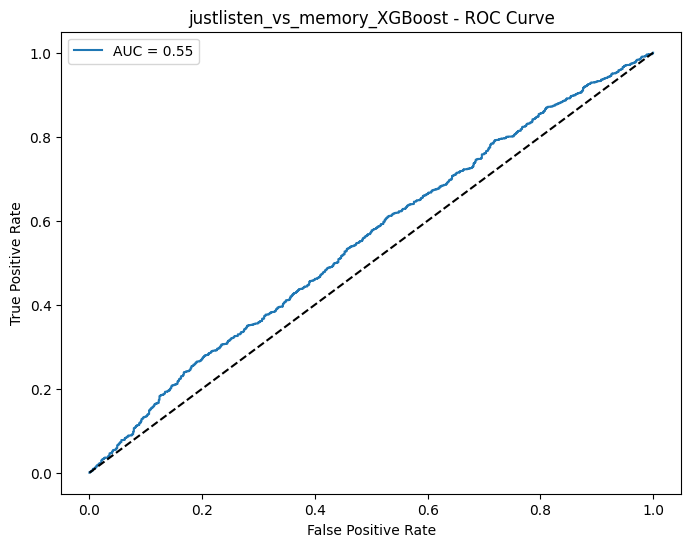

<Figure size 1000x600 with 0 Axes>

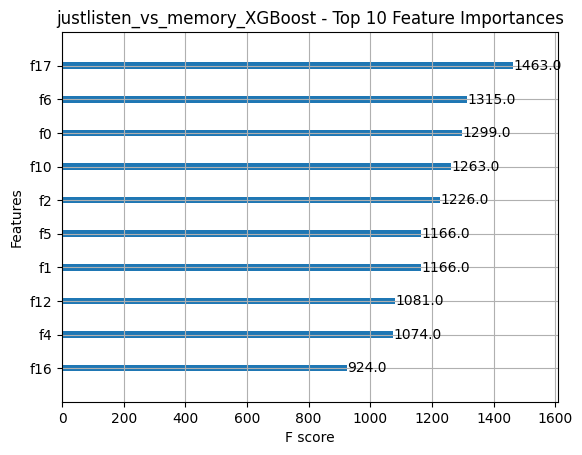

✅ Model saved as 'justlisten_vs_memory_XGBoost.joblib'


In [ ]:
# === Data Preparation for JustListen vs Memory Classifier ===
X_jm, y_jm = [], []
for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        for subcond_idx in range(3):
            for trial_idx in range(54):
                signal = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(signal).all():
                    label = 0 if subcond_idx == 0 else 1  # JustListen = 0, Memory = 1
                    X_jm.append(signal)
                    y_jm.append(label)

X_jm = np.array(X_jm)
print("\n📉 Normalizing and downsampling binary signals...")
X_jm = clean_signals(X_jm)
X_jm = downsample_signals(X_jm, target_len=2000)
print("✅ Shape after downsampling - X_jm:", X_jm.shape)

print("\n🔄 Extracting features for binary classifier...")
X_jm_features = extract_features(X_jm)

# === Models for JustListen vs Memory Classifier ===
binary_models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500, max_depth=10, min_samples_split=5,bootstrap= False, max_features='sqrt', min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        objective="binary:logistic", random_state=42, n_jobs=-1
    ),
}

# === Training on Binary Classifier ===
for model_name, model in binary_models.items():
    train_classifier(X_jm_features, np.array(y_jm), ["JustListen", "Memory"], model, f"justlisten_vs_memory_{model_name}", is_binary=True)



📉 Normalizing and downsampling 4-class signals...
✅ Shape after downsampling - X_4c: (10241, 2000)

🔄 Extracting features for 4-class classifier...


🔍 Extracting Catch22: 100%|██████████| 10241/10241 [03:03<00:00, 55.69it/s]



⚙️ Training classifier: fourclass_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.7411 ± 0.0045
⏱️ Training Time: 14.49 seconds

✅ Test Accuracy: 0.6704

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.41      0.04      0.08       813
        Five       0.67      0.96      0.79       599
        Nine       0.70      0.95      0.81       585
    Thirteen       0.67      0.97      0.79       564

    accuracy                           0.67      2561
   macro avg       0.61      0.73      0.62      2561
weighted avg       0.59      0.67      0.57      2561



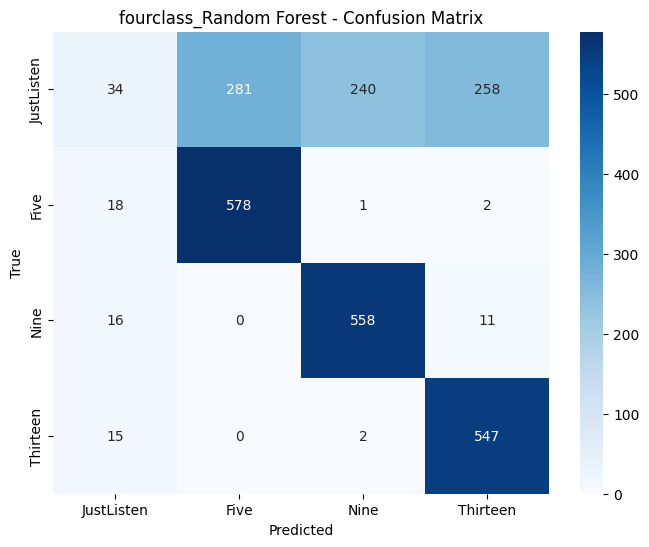

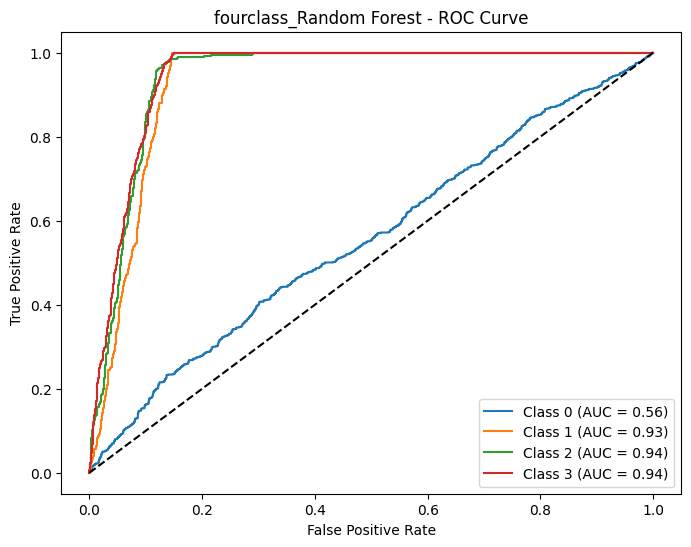

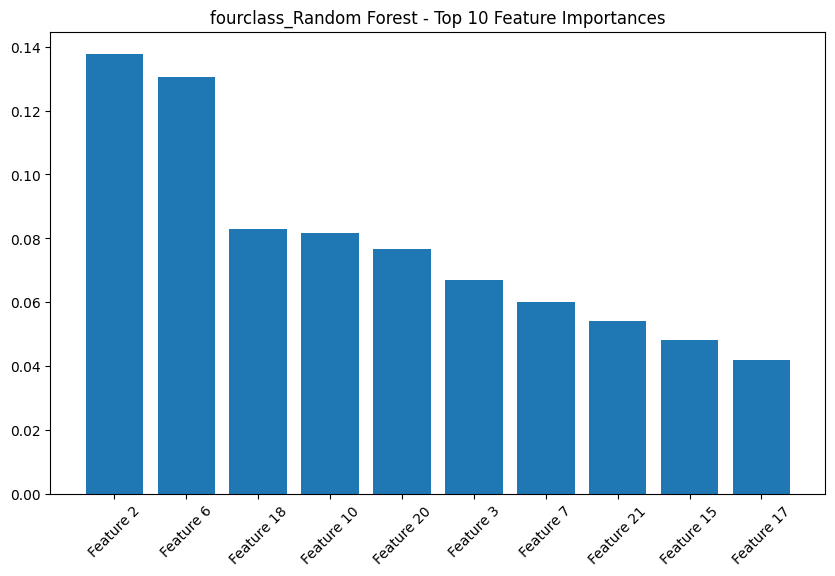

✅ Model saved as 'fourclass_Random Forest.joblib'

⚙️ Training classifier: fourclass_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.6760 ± 0.0063
⏱️ Training Time: 18.16 seconds

✅ Test Accuracy: 0.6205

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.33      0.00      0.01       813
        Five       0.66      0.93      0.77       599
        Nine       0.66      0.84      0.74       585
    Thirteen       0.56      0.96      0.70       564

    accuracy                           0.62      2561
   macro avg       0.55      0.68      0.56      2561
weighted avg       0.53      0.62      0.51      2561



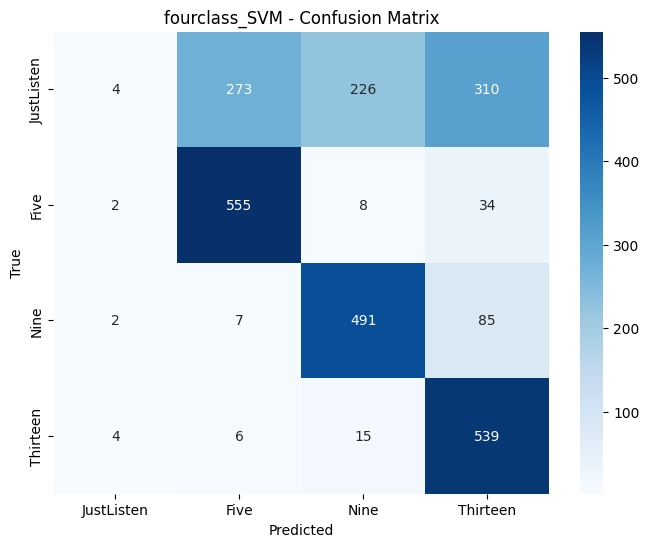

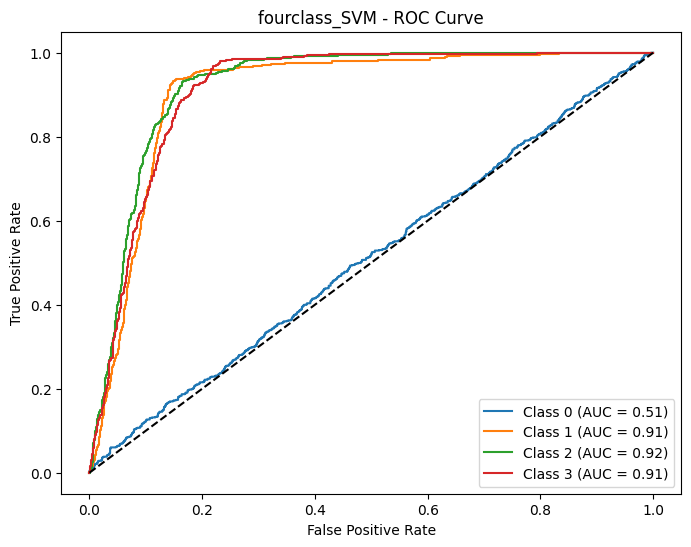

✅ Model saved as 'fourclass_SVM.joblib'

⚙️ Training classifier: fourclass_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.7286 ± 0.0026
⏱️ Training Time: 20.41 seconds

✅ Test Accuracy: 0.6373

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.36      0.16      0.22       813
        Five       0.68      0.87      0.76       599
        Nine       0.69      0.86      0.76       585
    Thirteen       0.69      0.85      0.76       564

    accuracy                           0.64      2561
   macro avg       0.60      0.68      0.63      2561
weighted avg       0.58      0.64      0.59      2561



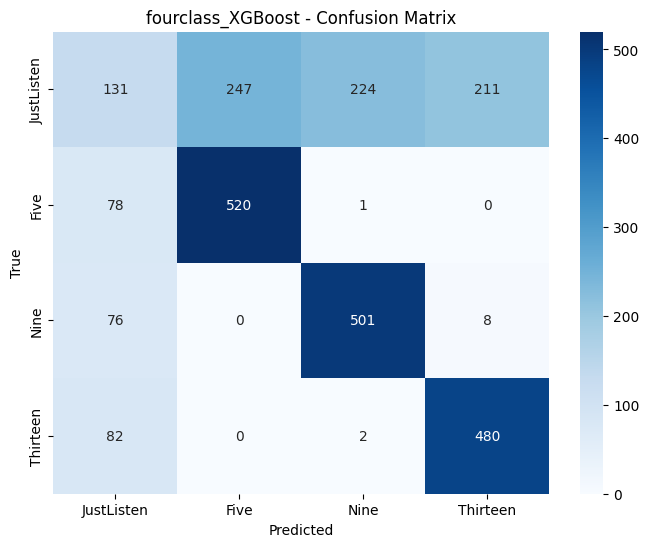

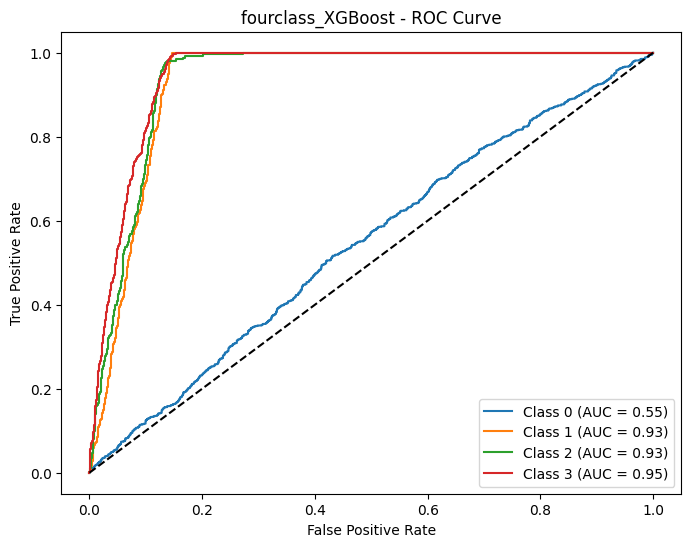

<Figure size 1000x600 with 0 Axes>

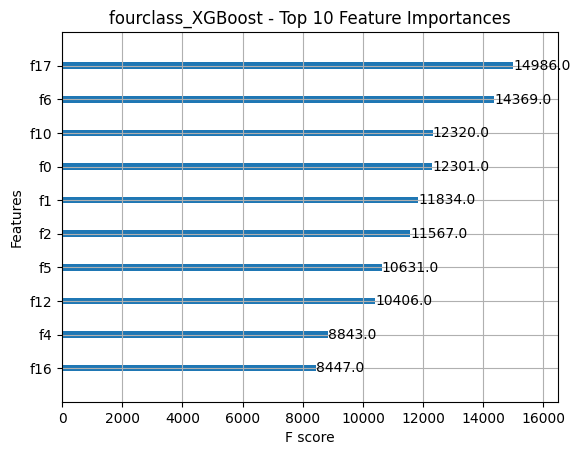

✅ Model saved as 'fourclass_XGBoost.joblib'


In [ ]:
# === Data Preparation for 4-Class Classifier ===

# 4-Class Label Mapping
fourclass_label_map = {
    "JustListen": 0,
    "Five": 1,
    "Nine": 2,
    "Thirteen": 3
}

X_4c, y_4c = [], []
for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        # JustListen
        for trial_idx in range(54):
            signal = subj_data[cond_idx, 0, trial_idx, :]
            if not np.isnan(signal).all():
                X_4c.append(signal)
                y_4c.append(fourclass_label_map["JustListen"])
# Add memory trials similarly with correct label mapping
        # MemoryCorrect + MemoryIncorrect
        for subcond_idx in [1, 2]:
            for trial_idx in range(54):
                signal = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(signal).all():
                    label = fourclass_label_map[["Five", "Nine", "Thirteen"][cond_idx]]
                    X_4c.append(signal)
                    y_4c.append(label)

X_4c = np.array(X_4c)
print("\n📉 Normalizing and downsampling 4-class signals...")
X_4c = clean_signals(X_4c)
X_4c = downsample_signals(X_4c, target_len=2000)
print("✅ Shape after downsampling - X_4c:", X_4c.shape)

print("\n🔄 Extracting features for 4-class classifier...")
X_4c_features = extract_features(X_4c)

# === Models for 4-Class Classifier ===
fourclass_models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500, max_depth=10, min_samples_split=5, bootstrap=False, max_features='sqrt', min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500, max_depth=10, learning_rate=0.05,
        objective="multi:softprob", random_state=42, n_jobs=-1
    ),
}

# === Training on 4-Class Classifier ===
for model_name, model in fourclass_models.items():
    train_classifier(X_4c_features, np.array(y_4c), list(fourclass_label_map.keys()), model, f"fourclass_{model_name}", is_binary=False)
